In [1]:
# libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt

#Metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef
#Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the dataset
df = pd.read_parquet("../data/processed/merged_data.parquet")
df

,track_id,genre,title,artist_name,duration,year_x,&,000,1,10,...,è,é,él,és,était,être,ô,über,–,‘caus
1,TRAAABD128F429CF47,Pop_Rock,Soul Deep,The Box Tops,148.03546,1969,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TRAAAEF128F4273421,Pop_Indie,Something Girls,Adam Ant,233.40363,1982,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TRAAAFD128F92F423A,Pop_Rock,Face the Ashes,Gob,209.60608,2007,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,TRAAAHJ128F931194C,Pop_Indie,The Last Beat Of My Heart (b-side),Devotchka,337.81506,2004,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,TRAAAHZ128E0799171,Rap,The One And Only (Edited),Snoop Dogg,230.42567,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127395,TRZZZLI128F147BC2E,Pop_Rock,China De Sade (Album Version),My Life With The Thrill Kill Kult,268.40771,1993,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127396,TRZZZMM128F42819C0,Pop_Rock,Tables Will Turn,Presence,265.61261,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127397,TRZZZQO128E078864C,Metal_Heavy,Weight Of The World (LP Version),Overkill,247.17016,1993,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127398,TRZZZWS128F429CF87,Latin,Que No Destrocen Tu Vida,Los Prisioneros,256.31302,1987,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#obtain class labels for future use 
classes = df['genre'].value_counts().index.tolist()
classes

['Pop_Rock',
 'Metal_Alternative',
 'Rock_Contemporary',
 'Pop_Indie',
 'Rock_College',
 'Rock_Hard',
 'Metal_Death',
 'Metal_Heavy',
 'Latin',
 'Rap']

In [4]:
# Train, test split
df = df.set_index("track_id")
X = df.drop(columns=["genre", "title", "artist_name"]).copy()
y = df["genre"].copy()

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

In [7]:
# select classifiers
# classifiers = [
#     DecisionTreeClassifier(max_depth=2, random_state=42),
#     SVC(kernel='linear', C=1, random_state=42),
#     GaussianNB(),
#     KNeighborsClassifier(n_neighbors=7),
#     LogisticRegression(solver="saga", n_jobs=-1, random_state=42),
# ]
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from scipy.special import softmax

def softprob_obj(labels: np.ndarray, predt: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    rows = labels.shape[0]
    classes = predt.shape[1]
    grad = np.zeros((rows, classes), dtype=float)
    hess = np.zeros((rows, classes), dtype=float)
    eps = 1e-6
    for r in range(predt.shape[0]):
        target = labels[r]
        p = softmax(predt[r, :])
        for c in range(predt.shape[1]):
            g = p[c] - 1.0 if c == target else p[c]
            h = max((2.0 * p[c] * (1.0 - p[c])).item(), eps)
            grad[r, c] = g
            hess[r, c] = h

    grad = grad.reshape((rows * classes, 1))
    hess = hess.reshape((rows * classes, 1))
    return grad, hess

classifiers = [
    LogisticRegression(random_state=42, class_weight="balanced", solver="saga", n_jobs=-1),
    HistGradientBoostingClassifier(random_state=42, class_weight="balanced", scoring="balanced_accuracy"),
    XGBClassifier(random_state=42, n_jobs=-1, tree_method="hist", objective=softprob_obj)
]

In [8]:
#Write function for class-centric metrics
# Classification report
def CR_viz():
    def Class_report(model,classes):
        visualizer = ClassificationReport(model, classes=classes, support=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        return visualizer.poof()
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        Class_report(name,classes)

#Class Prediction Error
def CPE_viz():    
    def CPE(model,classes):
        visualizer = ClassPredictionError(model, classes=classes)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CPE(name,classes)
        
#Confusion matrix
def CM_viz():    
    def CM(model,classes):
        visualizer = ConfusionMatrix(model, classes=classes,percent=True)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        CM(name,classes)
        
#ROC-AUC
def ROC_viz():    
    def ROC(model,classes):
        visualizer = ROCAUC(model, classes=classes)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        ROC(name,classes)

#Precision Recall Curve
def PRC_viz():  
    def PRC(model,classes):
        visualizer = PrecisionRecallCurve(model,classes=classes, per_class=True, iso_f1_curves=False,
    fill_area=False, micro=False)
        visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
        return visualizer.poof()  
    for name in classifiers:
        ax = plt.subplot(1,1,1)
        PRC(name,classes)


In [9]:
# Write function for aggregate metrics
def classifier_metrics():    
    def metrics(model):
        #     model=model_name()
        model.fit(X_train, y_train)  # Fit the visualizer and the model
        y_pred = model.predict(X_test)
        try: 
            y_prob = model.predict_proba(X_test)
            log_metric = log_loss(y_test,y_prob)
        except:
            y_prob = "Not probabilistic"
            log_metric = 0
        else:
            y_pred = model.predict(X_test)
        c_k_s=cohen_kappa_score(y_test,y_pred)
        zero_met=zero_one_loss(y_test,y_pred)
        hl=hamming_loss(y_test,y_pred)
        mc=matthews_corrcoef(y_test,y_pred)
        print('cohen_kappa_score: {0:.3f}'.format(c_k_s))
        print('log_loss: {0:.3f}'.format(log_metric))
        print('zero_one_loss: {0:.3f}'.format(zero_met))
        print('hemming_loss: {0:.3f}'.format(hl))
        print('matthews_corrcoef: {0:.3f}'.format(mc))
    for name in classifiers:
        print(str(name))
        metrics(name)
        print()
        print("------------------------------------------------------")

In [10]:
#deploy visualization
# visualization =[CR_viz(),CPE_viz(),CM_viz(),ROC_viz(),PRC_viz()]

In [11]:
# CR_viz()

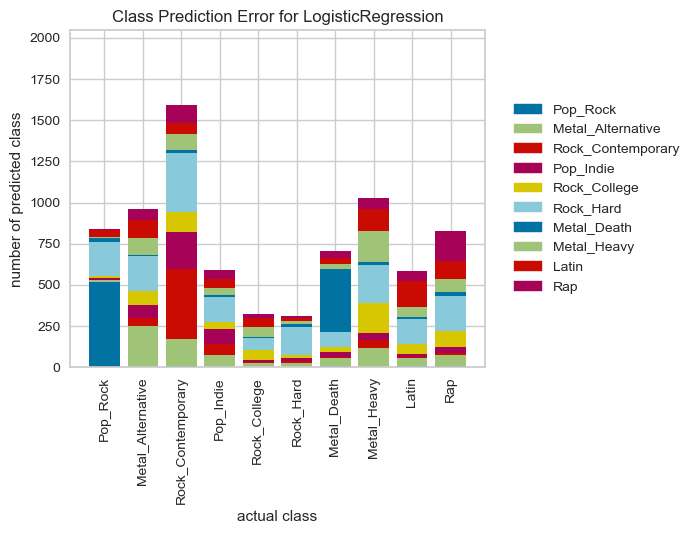

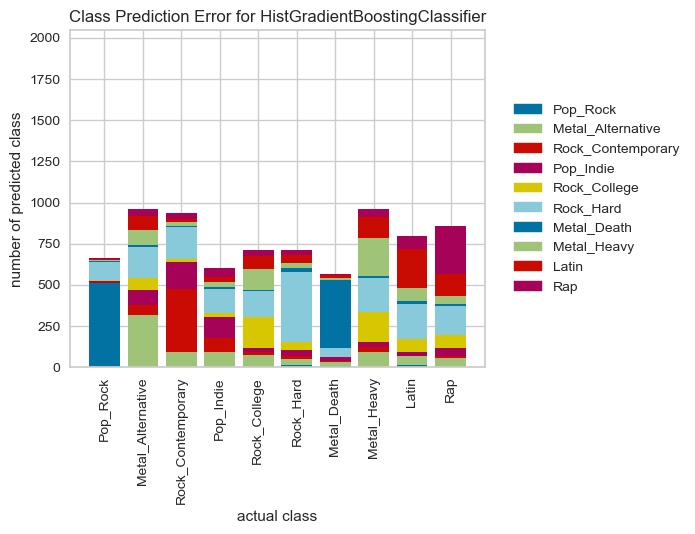

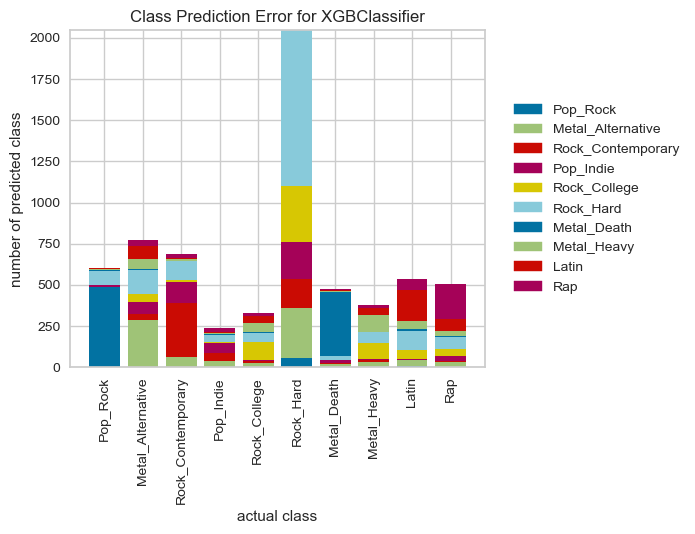

In [12]:
CPE_viz()

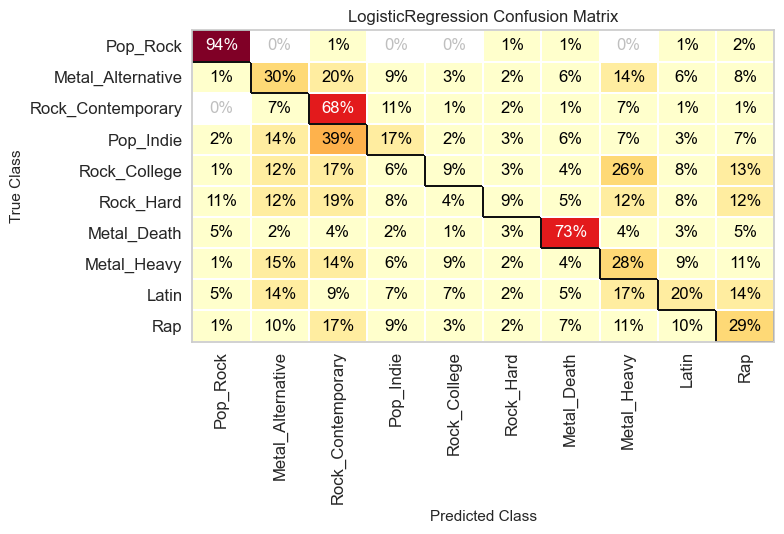

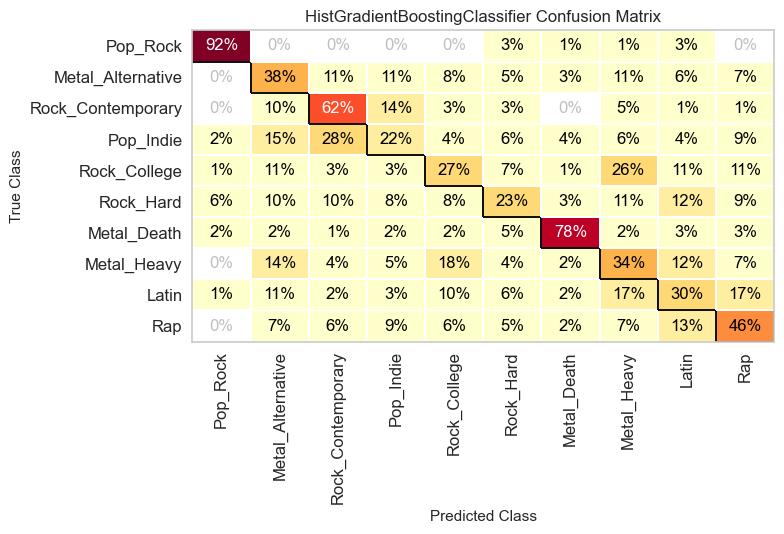

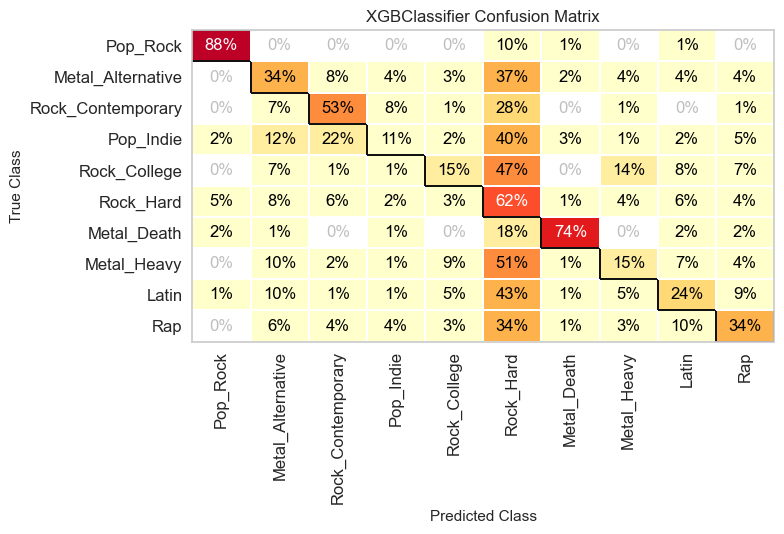

In [13]:
CM_viz()

In [14]:
# ROC_viz()

In [15]:
# PRC_viz()

In [16]:
#Deploy aggregate metrics  
classifier_metrics()

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42,
                   solver='saga')
cohen_kappa_score: 0.247
log_loss: 1.912
zero_one_loss: 0.685
hemming_loss: 0.685
matthews_corrcoef: 0.256

------------------------------------------------------
HistGradientBoostingClassifier(class_weight='balanced', random_state=42,
                               scoring='balanced_accuracy')
cohen_kappa_score: 0.336
log_loss: 1.620
zero_one_loss: 0.597
hemming_loss: 0.597
matthews_corrcoef: 0.341

------------------------------------------------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_ra